# Implementing a Neural Network
Developing a neural network with fully-connected layers to perform classification and testing it out on the CIFAR-10 dataset.

In [1]:
# Setup.
import numpy as np
import matplotlib.pyplot as plt

from cs231n.classifiers.neural_net import TwoLayerNet

import warnings
warnings.filterwarnings("ignore")

%matplotlib inline
plt.rcParams["figure.figsize"] = (10.0, 8.0) # set default size of plots
plt.rcParams["image.interpolation"] = "nearest"
plt.rcParams["image.cmap"] = "gray"

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

We use the class `TwoLayerNet` in the file `cs231n/classifiers/neural_net.py` to represent instances of our network. The network parameters are stored in the instance variable `self.params` where keys are string parameter names and values are numpy arrays. Below, we initialize toy data and a toy model that we will use to develop the implementation.

In [2]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([0, 1, 2, 2, 1])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Relevant code in `cs231n/classifiers/neural_net.py`.

In [3]:
scores = net.loss(X)
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])

# The difference should be very small. We get < 1e-7
print("Difference between your scores and correct scores:")
print(np.sum(np.abs(scores - correct_scores)))

Difference between your scores and correct scores:
3.68027207103e-08


# Forward pass: compute loss

In [4]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 1.30378789133

# should be very small, we get < 1e-12
print("Difference between your loss and correct loss:")
print(np.sum(np.abs(loss - correct_loss)))

Difference between your loss and correct loss:
1.79412040779e-13


# Backward pass

In [5]:
from cs231n.gradient_check import eval_numerical_gradient

# Check implementation of the backwards pass using numeric gradient checking. 
loss, grads = net.loss(X, y, reg=0.05)

# These should all be less than 1e-8 or so.
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.05)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name], verbose=False)
    print("%s max relative error: %e" % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.440708e-09
b1 max relative error: 2.738420e-09
b2 max relative error: 4.447625e-11
W1 max relative error: 3.561318e-09


# Train the network using stochastic gradient descent
Relevant code in `TwoLayerNet.train`.

Final training loss:  0.0171436435329


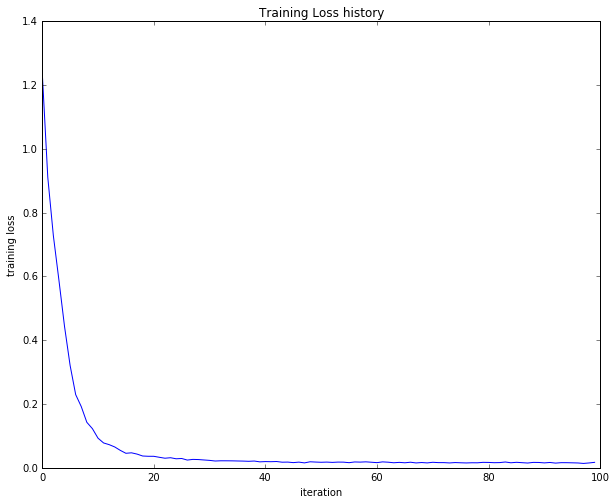

In [6]:
net = init_toy_model()
stats = net.train(X, y, X, y,
            learning_rate=1e-1, reg=5e-6,
            num_iters=100, verbose=False)

# Should be less than 0.2. 
print("Final training loss: ", stats["loss_history"][-1])

# plot the loss history
plt.plot(stats["loss_history"])
plt.xlabel("iteration")
plt.ylabel("training loss")
plt.title("Training Loss history")
plt.show()

# Load the CIFAR-10 data

In [7]:
from cs231n.data_utils import load_CIFAR10

def get_CIFAR10_data(num_training=49000, num_validation=1000, num_test=1000):
    """
    Load the CIFAR-10 dataset from disk and perform preprocessing to prepare
    it for the two-layer neural net classifier. These are the same steps as
    we used for the SVM, but condensed to a single function.  
    """
    # Load the raw CIFAR-10 data
    cifar10_dir = "cs231n/datasets/cifar-10-batches-py"
    X_train, y_train, X_test, y_test = load_CIFAR10(cifar10_dir)
        
    # Subsample the data
    mask = list(range(num_training, num_training + num_validation))
    X_val = X_train[mask]
    y_val = y_train[mask]
    mask = list(range(num_training))
    X_train = X_train[mask]
    y_train = y_train[mask]
    mask = list(range(num_test))
    X_test = X_test[mask]
    y_test = y_test[mask]

    # Normalize the data: subtract the mean image
    mean_image = np.mean(X_train, axis=0)
    X_train -= mean_image
    X_val -= mean_image
    X_test -= mean_image

    # Reshape data to rows
    X_train = X_train.reshape(num_training, -1)
    X_val = X_val.reshape(num_validation, -1)
    X_test = X_test.reshape(num_test, -1)

    return X_train, y_train, X_val, y_val, X_test, y_test


# Invoke the above function to get our data.
X_train, y_train, X_val, y_val, X_test, y_test = get_CIFAR10_data()
print("Train data shape: ", X_train.shape)
print("Train labels shape: ", y_train.shape)
print("Validation data shape: ", X_val.shape)
print("Validation labels shape: ", y_val.shape)
print("Test data shape: ", X_test.shape)
print("Test labels shape: ", y_test.shape)

Train data shape:  (49000, 3072)
Train labels shape:  (49000,)
Validation data shape:  (1000, 3072)
Validation labels shape:  (1000,)
Test data shape:  (1000, 3072)
Test labels shape:  (1000,)


# Train a network
To train our network we will use SGD with momentum. In addition, we will adjust the learning rate with an exponential learning rate schedule as optimization proceeds; after each epoch, we will reduce the learning rate by multiplying it by a decay rate.

In [8]:
input_size = 32 * 32 * 3
hidden_size = 50
num_classes = 10
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=1000, batch_size=200,
            learning_rate=1e-4, learning_rate_decay=0.95,
            reg=0.25, verbose=True)

# Predict on the validation set
val_acc = (net.predict(X_val) == y_val).mean()
print("Validation accuracy: ", val_acc) 

iteration 0 / 1000: loss 2.302762
iteration 100 / 1000: loss 2.302358
iteration 200 / 1000: loss 2.297404
iteration 300 / 1000: loss 2.258897
iteration 400 / 1000: loss 2.202975
iteration 500 / 1000: loss 2.116816
iteration 600 / 1000: loss 2.049789
iteration 700 / 1000: loss 1.985711
iteration 800 / 1000: loss 2.003726
iteration 900 / 1000: loss 1.948076
Validation accuracy:  0.287


# Debug the training
With the above parameters, we achieve a validation accuracy of around 0.29. 

To figure out what's going on, we can plot the loss function and accuracies on the training and validation sets udirng optimisation.

We can also visualise the weights that were learned in the first layer of the network, which should show some visual structure. 

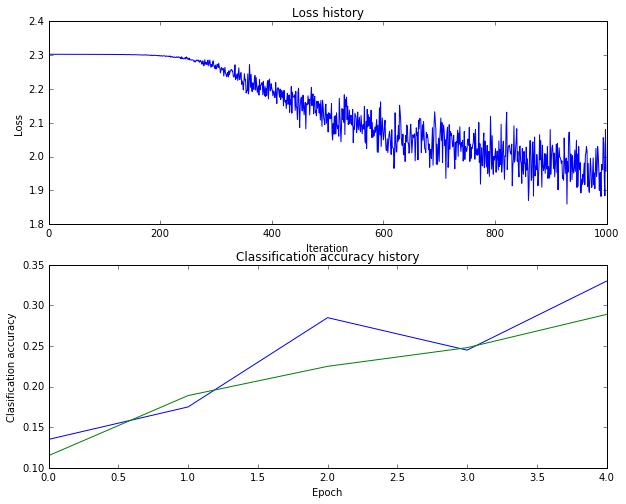

In [9]:
# Plot the loss function and train / validation accuracies
plt.subplot(2, 1, 1)
plt.plot(stats["loss_history"])
plt.title("Loss history")
plt.xlabel("Iteration")
plt.ylabel("Loss")

plt.subplot(2, 1, 2)
plt.plot(stats["train_acc_history"], label="train")
plt.plot(stats["val_acc_history"], label="val")
plt.title("Classification accuracy history")
plt.xlabel("Epoch")
plt.ylabel("Clasification accuracy")
plt.show()

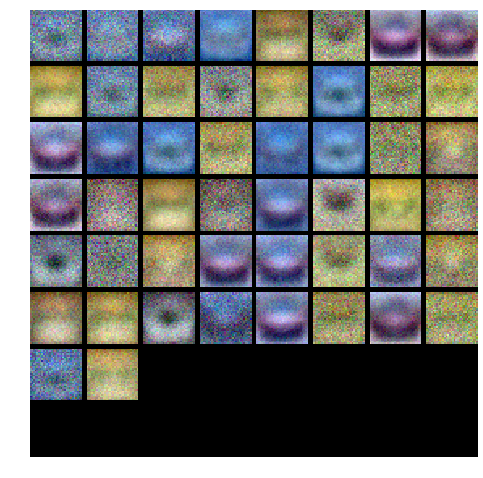

In [10]:
from cs231n.vis_utils import visualize_grid

# Visualize the weights of the network

def show_net_weights(net):
    W1 = net.params["W1"]
    W1 = W1.reshape(32, 32, 3, -1).transpose(3, 0, 1, 2)
    plt.imshow(visualize_grid(W1, padding=3).astype("uint8"))
    plt.gca().axis("off")
    plt.show()

show_net_weights(net)

# Tune hyperparameters

**What's wrong?**. Looking at the visualizations above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy.

Below, we experiment with different hyperparameter values (hidden layer size, learning rate, number of epochs and regularisation strength) to figure out what's going on. 

We should be able to achieve a classification of 48-52% on the validation set. 

In [11]:
best_net = None
results = {}
best_val = -1

num_epochs = [1500, 2000, 5000, 10000]
learning_rates = [1e-4, 2e-4, 2.5e-4, 5e-4, 7.5e-4, 10e-4]
regularisation_strengths = [0.01, 0.1, 0.25, 0.5, 0.75, 1]

for num_epoch in num_epochs:
    for lr in learning_rates:
        for reg in regularisation_strengths:
            net = TwoLayerNet(input_size, hidden_size, num_classes)
            # Train the network
            stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=num_epoch, batch_size=200,
            learning_rate=lr, learning_rate_decay=0.95,
            reg= reg, verbose=False)
            val_acc = (net.predict(X_val) == y_val).mean()
            if val_acc > best_val:
                best_val = val_acc
                best_net = net         
            results[(lr,reg)] = val_acc

# Print out results.
for lr, reg in sorted(results):
    val_acc = results[(lr, reg)]
    print("lr %e reg %e val accuracy: %f" % (
                lr, reg,  val_acc))

lr 1.000000e-04 reg 1.000000e-02 val accuracy: 0.459000
lr 1.000000e-04 reg 1.000000e-01 val accuracy: 0.443000
lr 1.000000e-04 reg 2.500000e-01 val accuracy: 0.451000
lr 1.000000e-04 reg 5.000000e-01 val accuracy: 0.463000
lr 1.000000e-04 reg 7.500000e-01 val accuracy: 0.453000
lr 1.000000e-04 reg 1.000000e+00 val accuracy: 0.449000
lr 2.000000e-04 reg 1.000000e-02 val accuracy: 0.482000
lr 2.000000e-04 reg 1.000000e-01 val accuracy: 0.492000
lr 2.000000e-04 reg 2.500000e-01 val accuracy: 0.472000
lr 2.000000e-04 reg 5.000000e-01 val accuracy: 0.489000
lr 2.000000e-04 reg 7.500000e-01 val accuracy: 0.484000
lr 2.000000e-04 reg 1.000000e+00 val accuracy: 0.475000
lr 2.500000e-04 reg 1.000000e-02 val accuracy: 0.509000
lr 2.500000e-04 reg 1.000000e-01 val accuracy: 0.492000
lr 2.500000e-04 reg 2.500000e-01 val accuracy: 0.498000
lr 2.500000e-04 reg 5.000000e-01 val accuracy: 0.503000
lr 2.500000e-04 reg 7.500000e-01 val accuracy: 0.495000
lr 2.500000e-04 reg 1.000000e+00 val accuracy: 0

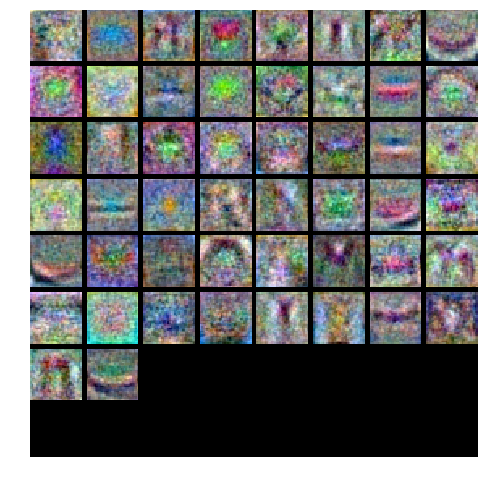

In [12]:
# visualize the weights of the best network
show_net_weights(best_net)

# Run on the test set
Should be above 48%.

In [13]:
test_acc = (best_net.predict(X_test) == y_test).mean()
print("Test accuracy: ", test_acc)

Test accuracy:  0.518
